# Set up

In [1]:
import torchreid
from torchreid.data.datasets.image.til2023_cv_test import Til2023CvTest
torchreid.data.register_image_dataset('til2023_cv_test', Til2023CvTest)

/notebooks/deep-person-reid/torchreid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


In [2]:
datamanager = torchreid.data.ImageDataManager(
    root='reid-data',
    sources='til2023_cv_test'
)

Building train transforms ...
+ resize to 256x128
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
TRAIN:::  [('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00066_5618.png', 66, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00175_3145.png', 175, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00158_5614.png', 158, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00060_4026.png', 60, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00156_4167.png', 156, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00107_3907.png', 107, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00067_2344.png

# Assemble Model

## model 1 - resnet50

In [4]:
model = torchreid.models.build_model(
    name="resnet50",
    num_classes=datamanager.num_train_pids,
    loss="softmax",
    pretrained=True
)

model = model.cuda()

optimizer = torchreid.optim.build_optimizer(
    model,
    optim="adam",
    lr=0.0003
)

scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler="single_step",
    stepsize=20
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## mode 2 - resnet50mid

## model 6 - osnet_ain_x0_25

In [3]:
model = torchreid.models.build_model(
    name="osnet_ain_x0_25",
    num_classes=datamanager.num_train_pids,
    loss="softmax",
    pretrained=True
)

model = model.cuda()

optimizer = torchreid.optim.build_optimizer(
    model,
    optim="adam",
    lr=0.0003
)

scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler="single_step",
    stepsize=20
)

Downloading...
From: https://drive.google.com/uc?id=1SxQt2AvmEcgWNhaRb2xC4rP6ZwVDP0Wt
To: /root/.cache/torch/checkpoints/osnet_ain_x0_25_imagenet.pth
100%|██████████| 3.08M/3.08M [00:00<00:00, 60.3MB/s]


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_ain_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


# Assemble engine, load weights

In [5]:
engine = torchreid.engine.ImageSoftmaxEngine(
    datamanager,
    model,
    optimizer=optimizer,
    scheduler=scheduler,
    label_smooth=True
)

In [6]:
from torchreid.utils import load_pretrained_weights

In [7]:
weight_path = '/notebooks/deep-person-reid/log/til_resnet50/model/model.pth.tar-4'

In [8]:
load_pretrained_weights(model, weight_path)

Successfully loaded pretrained weights from "/notebooks/deep-person-reid/log/til_resnet50/model/model.pth.tar-4"


In [9]:
_,distmat, queries_and_galley = engine.run(
    save_dir="log/til_resnet50",
    max_epoch=4,
    eval_freq=1,
    print_freq=50,
    test_only=True
)

##### Evaluating til2023_cv_test (source) #####
Extracting features from query set ...
HELLO HERE ARE UR PIDS AND CAMIDS: 
[0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]
Done, obtained 1600-by-2048 matrix
Extracting features from gallery set ...
HELLO HERE ARE UR PIDS AND CAMIDS: 
[0 0 0 ... 0 0 0] [2 2 2 ... 2 2 2]
Done, obtained 3406-by-2048 matrix
Speed: 0.0332 sec/batch
Computing distance matrix with metric=euclidean ...
YOUR DISTMAT!!!:  (1600, 3406)
[688.2606  404.26224 559.66675 ... 667.3122  682.7761  574.3227 ]
[823.1656  602.64624 598.3482  ... 765.1115  757.18115 408.59497]
[703.2411  573.1483  544.7986  ... 607.34814 709.7041  556.0141 ]
[936.87915 701.8567  696.475   ... 798.3012  819.5753  571.1512 ]
[548.3349  498.3891  520.37714 ... 335.8656  645.5317  524.24084]
[633.97675 500.94647 467.94638 ... 583.07623 662.5707  430.82874]
[696.97595 545.16327 514.8272  ... 539.35345 618.6189  537.45593]
[705.857   596.60266 594.1373  ... 599.542   566.1232  739.322  ]
[680.54474 575.63696 69

# post process results

In [11]:
from PIL import Image

In [58]:
def visualise_matches(d, q, index):
    query = q[0][index][0]
    distmat = d[index]
    gallery = q[1]
    
    temp = zip(distmat, gallery)
    print("#SUS ", query)
    im=Image.open(query)
    im.show()
    for i in sorted(temp):
        if query[-8:-4] in i[1][0][-13:-8]:
            print("#CANDIDATES: ", i)
            im=Image.open(i[1][0])
            im.show()

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0913.png


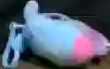

#CANDIDATES:  (402.69876, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0913_1940.png', 0, 2, 0))


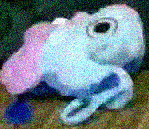

#CANDIDATES:  (623.5524, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0913_1939.png', 0, 2, 0))


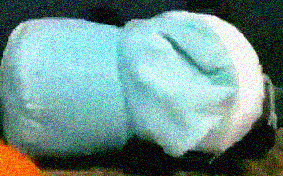

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0881.png


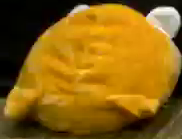

#CANDIDATES:  (511.31735, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0881_1879.png', 0, 2, 0))


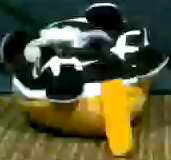

#CANDIDATES:  (621.25165, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0881_1878.png', 0, 2, 0))


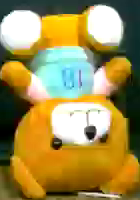

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1101.png


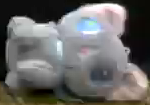

#CANDIDATES:  (168.00555, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1101_2363.png', 0, 2, 0))


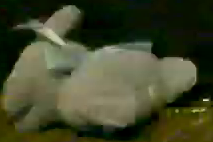

#CANDIDATES:  (554.05273, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1101_2362.png', 0, 2, 0))


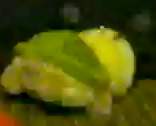

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0800.png


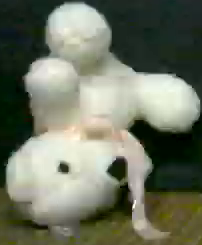

#CANDIDATES:  (175.5546, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0800_1708.png', 0, 2, 0))


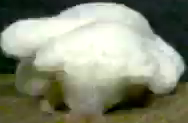

#CANDIDATES:  (597.865, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0800_1709.png', 0, 2, 0))


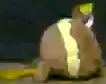

#CANDIDATES:  (634.98846, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0800_1707.png', 0, 2, 0))


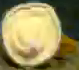

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0339.png


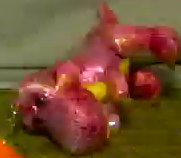

#CANDIDATES:  (73.573044, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0339_0704.png', 0, 2, 0))


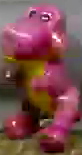

#CANDIDATES:  (792.33997, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0339_0703.png', 0, 2, 0))


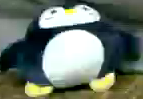

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0603.png


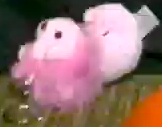

#CANDIDATES:  (93.84646, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0603_1282.png', 0, 2, 0))


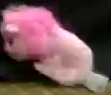

#CANDIDATES:  (349.56146, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0603_1281.png', 0, 2, 0))


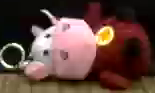

#CANDIDATES:  (741.1791, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0603_1283.png', 0, 2, 0))


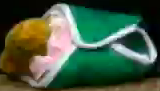

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0536.png


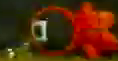

#CANDIDATES:  (432.8481, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0536_1139.png', 0, 2, 0))


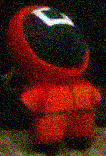

#CANDIDATES:  (735.26965, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0536_1141.png', 0, 2, 0))


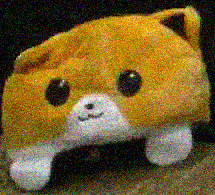

#CANDIDATES:  (783.3144, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0536_1140.png', 0, 2, 0))


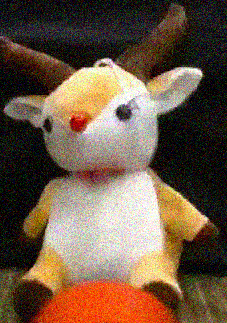

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1510.png


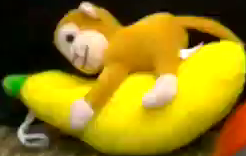

#CANDIDATES:  (582.3602, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1510_3212.png', 0, 2, 0))


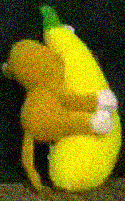

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1145.png


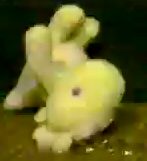

#CANDIDATES:  (125.61441, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1145_2453.png', 0, 2, 0))


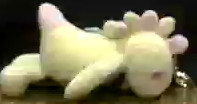

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1542.png


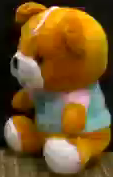

#CANDIDATES:  (436.34314, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1542_3276.png', 0, 2, 0))


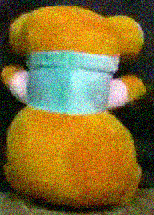

#CANDIDATES:  (746.47284, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1542_3274.png', 0, 2, 0))


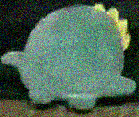

#CANDIDATES:  (750.76556, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1542_3275.png', 0, 2, 0))


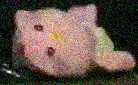

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1435.png


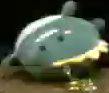

#CANDIDATES:  (573.8554, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1435_3047.png', 0, 2, 0))


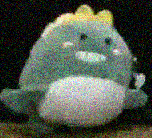

#CANDIDATES:  (742.9615, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1435_3045.png', 0, 2, 0))


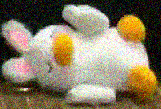

#CANDIDATES:  (749.2712, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1435_3046.png', 0, 2, 0))


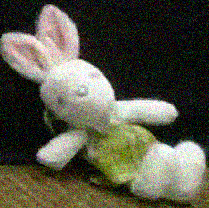

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0593.png


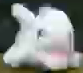

#CANDIDATES:  (330.7268, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0593_1259.png', 0, 2, 0))


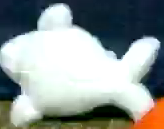

#CANDIDATES:  (406.1432, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0593_1260.png', 0, 2, 0))


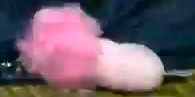

#CANDIDATES:  (708.97076, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0593_1261.png', 0, 2, 0))


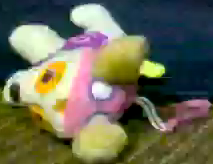

In [59]:
for i in range(944, 956):
    visualise_matches(distmat, queries_and_galley, i)

In [54]:
def output_matches(d, q, index):
    query = q[0][index][0]
    distmat = d[index]
    gallery = q[1]
    
    temp = zip(distmat, gallery)
    # print(query)
    # im=Image.open(query)
    # im.show()
    
    output = {}
    for i in sorted(temp):
        if query[-8:-4] in i[1][0][-13:-8]:
            if i[0] < 400 and output == {}:
                output[int(i[1][0][-8:-4])] = 1
            else:
                output[int(i[1][0][-8:-4])] = 0
                
    return output

In [55]:
output_matches(distmat, queries_and_galley, 22)

{912: 1, 910: 0, 911: 0}

In [62]:
import pandas as pd
from pandas import DataFrame
path = "/notebooks/deep-person-reid/reid-data/dataepoch2.csv"
df = pd.read_csv(path)
df.head(10)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,image_0000,0,0.956654,0.668310,0.458844,0.802455,0.544721
1,image_0000,0,0.926381,0.644173,0.139925,0.779620,0.221009
2,image_0000,0,0.921721,0.632702,0.248414,0.782471,0.334031
3,image_0001,0,0.957138,0.741689,0.697222,0.884431,0.814440
4,image_0001,0,0.950481,0.590011,0.391353,0.951974,0.528478
5,image_0001,0,0.948515,0.729235,0.153742,0.888728,0.266504
6,image_0002,0,0.959682,0.705045,0.564205,0.896992,0.663039
7,image_0002,0,0.953128,0.698485,0.333341,0.859158,0.448662
8,image_0002,0,0.952899,0.720116,0.748604,0.874441,0.868367
9,image_0003,0,0.959391,0.634337,0.693626,0.927256,0.857668


In [65]:
for i in range(1600):
    output = output_matches(distmat, queries_and_galley, i)
    for j in output.keys():
        df.at[j,"class"] = output[j]

In [67]:
df.head(24)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,image_0000,0,0.956654,0.668310,0.458844,0.802455,0.544721
1,image_0000,0,0.926381,0.644173,0.139925,0.779620,0.221009
2,image_0000,1,0.921721,0.632702,0.248414,0.782471,0.334031
3,image_0001,0,0.957138,0.741689,0.697222,0.884431,0.814440
4,image_0001,0,0.950481,0.590011,0.391353,0.951974,0.528478
5,image_0001,0,0.948515,0.729235,0.153742,0.888728,0.266504
6,image_0002,1,0.959682,0.705045,0.564205,0.896992,0.663039
7,image_0002,0,0.953128,0.698485,0.333341,0.859158,0.448662
8,image_0002,0,0.952899,0.720116,0.748604,0.874441,0.868367
9,image_0003,0,0.959391,0.634337,0.693626,0.927256,0.857668
